In [2]:
from langchain.schema import Document

# Splitter
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Model
from langchain.chat_models import ChatOpenAI

# Embedding Support
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings

# Summarizer, use for map reduce
from langchain.chains.summarize import load_summarize_chain

# Data Science
import numpy as np
from sklearn.cluster import KMeans

from dotenv import find_dotenv, load_dotenv

In [3]:
_ = load_dotenv(find_dotenv())

## Load and split the podcast content

In [8]:
with open("huberman_transcripts.txt", "r") as f:
    text = f.read()

text_splitter = RecursiveCharacterTextSplitter(
    separators=['\n\n', '\n', '\t'],
    chunk_size=2000,
    chunk_overlap=400
)


## Embedd the docs

In [9]:
docs = text_splitter.create_documents([text])

embeddings = OpenAIEmbeddings()
vectors = embeddings.embed_documents([d.page_content for d in docs])

## With vectors in hand we can now find clusters

In [10]:
num_clusters = 10

# Perform K-means clustering 
kmeans = KMeans(n_init='auto', n_clusters=num_clusters, random_state=42).fit(vectors)

In [11]:
kmeans.labels_

array([3, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 7, 7, 9, 4, 4, 4, 4, 4,
       0, 0, 0, 0, 7, 7, 7, 6, 6, 6, 6, 4, 6, 2, 5, 5, 5, 5, 5, 5, 5, 5,
       3, 9, 9, 9, 9, 9, 9, 9, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 3],
      dtype=int32)

**This is sweet, but whenever you have a clustering exercise, it's hard not to graph them. Make sure you add colors.
We also need to do dimensionality reduction to reduce the vectors from 1536 dimensions to 2 (this is sloppy data science but we are working towards the
80% solutio**n)

## Reduce the cluster dimensions

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Taking out the warnings
import warnings
from warnings import simplefilter

In [13]:
# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

In [14]:
# Perform t-SNE and reduce to 2 dimensions
np_vectors = np.array(vectors)
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(np_vectors)

## Plot the reduced cluster

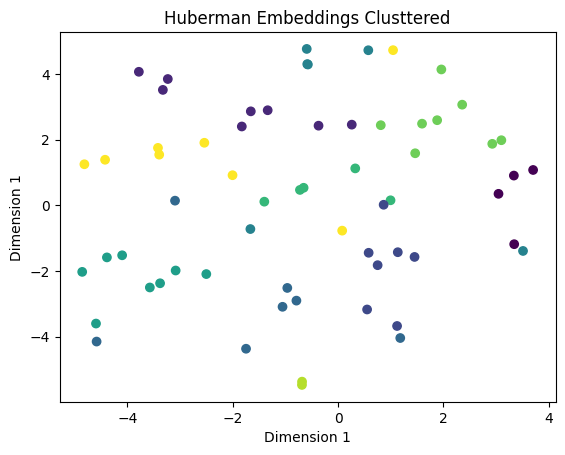

In [15]:
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 1')
plt.title('Huberman Embeddings Clusttered')
plt.show()

## Find the closest embeddings to the centroids

In [16]:
closest_incices = []

for i in range(num_clusters):

    # Get the list of distances from that particular cluster cneter
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)

    # Find the list position of closest one (using argmin to find the smalles distance)
    closest_index = np.argmin(distances)

    closest_incices.append(closest_index)


In [17]:
# These are the closest chunks to the center meaning
# from each cluster
selected_indices = sorted(closest_incices)
selected_indices

[1, 9, 12, 19, 24, 30, 40, 47, 55, 61]

## Prepare the summaring model

In [18]:
map_llm = ChatOpenAI(
    temperature=0,
    max_tokens=1000,
    model = 'gpt-3.5-turbo'
)

In [19]:
from langchain.prompts import PromptTemplate
map_prompt = """
You will be given a part of section transript from a podcast.\
The is section will be enclosed in triple backticks (```)\
Your goal is to give a summary of this section with domain knowledge of \
professional neuroscience so that a reader will have full understanding of what this\
section of podcast is about.
Your response should be at leat three paragraphs and fully encompass what was\
said in the part of podcast.

```{text}```

FULL SUMMARY: 
"""

map_prompt_template = PromptTemplate(template=map_prompt, input_variables=['text'])

In [20]:
map_chain = load_summarize_chain(
    llm=map_llm,
    prompt=map_prompt_template,
    chain_type="stuff"
)

## Start summarizing

In [21]:
# Select the chucks in our selected indicies
sorted_docs = [docs[i] for i in selected_indices]

In [22]:
sorted_docs[1].page_content

"twofold first Define the specific priority goal that you're going to pursue and set aside all other goal\nPursuits and in doing that it makes sense to pursue a somewhat loftier goal\nthan perhaps a more mundane goal or if you know exactly what goal you're going to prioritize that you try and Achieve\nperhaps more than you think you ought to be able to achieve within that given goal and within the goal that you decide\nto prioritize you want to set a level of progress a level of performance that you're striving to attain that's a bit\nabove what you actually believe at this time you can accomplish now in doing so\nyou are inevitably going to encounter some frustration and anxiety but remember the component of the neural\ncircuitry that we talked about at the beginning of the episode the orbital frontal cortex that orbital frontal\ncortex is not just part of a neural circuitry that assesses how we feel in a given moment as we are trying to pursue\na goal but it also understands context 

In [23]:
# Summarize every chunk
summary_list = []
for i, doc in enumerate(sorted_docs, start=1):
    chunk_summary = map_chain.run([doc])
    summary_list.append(chunk_summary)

    print(f"Summary #{i} (chunk #{selected_indices[i-1]}) - Preview: {chunk_summary[:250]}\n\n")

Summary #1 (chunk #1) - Preview: In this section of the podcast, the speaker discusses the importance of setting and achieving goals, particularly in relation to implementing certain protocols. The speaker expresses confidence that by following the protocols described, listeners wil


Summary #2 (chunk #9) - Preview: In this section of the podcast, the speaker discusses the importance of setting a specific priority goal and focusing all efforts on achieving that goal. They suggest pursuing a loftier goal rather than a mundane one, and pushing oneself to achieve m


Summary #3 (chunk #12) - Preview: In this section of the podcast, the speaker discusses the importance of defining and writing down goals in order to achieve them. They explain that while it may be obvious that certain activities, such as running or swimming, are necessary to improve


Summary #4 (chunk #19) - Preview: In this section of the podcast, the speaker discusses the concept of sharing goals with others and the pote

In [24]:
token_llm = ChatOpenAI()

In [31]:
summaries = "\n\n".join(summary_list)
# Convert it back to a document
summaries = Document(page_content=summaries)
print(f"Total summary has {token_llm.get_num_tokens(summaries.page_content)} tokens")

Total summary has 2977 tokens


In [26]:
summary_llm = ChatOpenAI(
    temperature=0,
    model='gpt-4',
    request_timeout=120
)

In [27]:
summary_template = """
You are a professional neuroscientist and very capable of giving reader \
great insights from neuroscience articles.

You are about to be given a series of summaries wrapped in triple backticks from a neuroscience podcast by Andrew Huberman.
Your goal is to give an insightful summary from those combined chunk of summaries, \
so that the reader should be able to learn the essence and salient points from this podcast.
Your response should be at leat three paragraphs and fully encompass what was said in those summaries.

SERIES OF SUMMARIES: ```{text}```

INSIGHTFUL SUMMARY:
"""

summary_prompt = PromptTemplate(template=summary_template, input_variables=["text"])

In [28]:
reduce_chain = load_summarize_chain(
    llm=summary_llm,
    prompt=summary_prompt,
    chain_type="stuff",
    verbose=True
)

In [29]:
response = reduce_chain.run([summaries])



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

You are a professional neuroscientist and very capable of giving readergreat insights from neuroscience articles.

You are about to be given a series of summaries wrapped in triple backticks from a neuroscience podcast of Andrew Huberman.Your goal is to give an insightful summary from those combined chunk of summaries,so that the reader should be able to learn the essence and salient points from this podcast.
Your response should be at leat three paragraphs and fully encompass what was said in those summaries.

SERIES OF SUMMARIES: ```In this section of the podcast, the speaker discusses the importance of setting and achieving goals, particularly in relation to implementing certain protocols. The speaker expresses confidence that by following the protocols described, listeners will have the best chance of both setting the right goals and successfully achieving them. It is emphasiz

In [30]:
print(response)

The podcast by Andrew Huberman delves into the science of setting and achieving goals, emphasizing the importance of specific, quantifiable objectives and the role of neuroplasticity in learning and progress. The speaker discusses the significance of writing down goals, as this engages neural circuitry differently than typing, and encourages listeners to identify obstacles and specific actions needed to overcome them. The role of the orbital frontal cortex in understanding the context of emotions such as frustration and anxiety, which are natural responses to errors, is also highlighted. This understanding is crucial for achieving neuroplasticity, the brain's ability to adapt and change, which ultimately leads to improved learning and performance.

The podcast also explores the concept of sharing goals, suggesting that it may be more beneficial to keep goals private and focus on personal accountability. The speaker introduces the idea of a 12-week quarterly cycle for goal setting, emph